In [7]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix
from scripts_tempHelix import generate_static_temporal_helix, generate_temporal_helix, multiple_exponential_temporal_helix

# New graph every step

In [24]:
def estimate_hitting_time(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps+1):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_temporal_helix(rep,0))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s == 0 or s == 1 or s % 5 == 0:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                graph = nx.from_numpy_array(generate_temporal_helix(rep,total_steps_this_simulation))
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def theoretical_hitting_time(reps,epsilon,factor):
    cover_times = []
    k = 0
    for n in range(1,reps+1):
        k = n**epsilon
        cover_times.append(2**(factor*k))
    return cover_times
       
    return hitting_times

In [38]:
epsilon = 0.50

reps = 6
nrange2 = [3 + 3*rep for rep in range(1,reps)]
nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
factor = 4.5

fromNode = 0
toNode = -1


samples = 10


hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeV2TemporalHelix_N{nrange2[0]}-{nrange2[-1]}_EPS{epsilon}_S{samples}.txt'

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    estimate_hitting_time_memory = [x for x in theoretical_hitting_time(reps,epsilon,factor)]
    print('File exists!')
else:
    print('File Doesnt Exist!')
    hitting_times = estimate_hitting_time(reps,fromNode,toNode, num_simulations=samples)
    write_list_to_file(hitting_times_file, hitting_times)
    estimate_hitting_time_memory = [x for x in theoretical_hitting_time(reps,epsilon,factor)]

File exists!


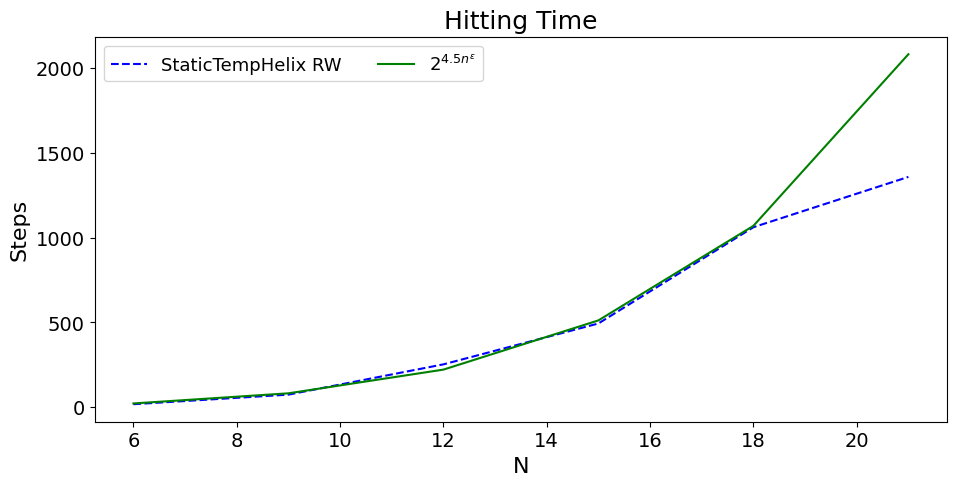

In [39]:
alphaLabelList = [r'StaticTempHelix RW',r'$2^{' +f'{factor}' +r'n^\epsilon}$']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(nrange3),list(nrange3)] , y_value_matrix = [hitting_times,estimate_hitting_time_memory],**params)